In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from operator import itemgetter as it
from itertools import repeat
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import matplotlib
import readability
import seaborn as sns
import pyphen
from wordcloud import WordCloud
import collections
import json

In [2]:
df=pd.read_csv('Data/notebook_aggregated_manifestos.csv')
df.head()

Unnamed: 0  year  participation party_name  result  \
0           0  DS_S          61.40      Store   11.00   
1           1  1949          78.49     CDUCSU   31.01   
2           2  1949          78.49        FDP   11.92   
3           3  1949          78.49      Linke     NaN   
4           4  1949          78.49        SPD   29.22   

                                                text type  
0   www.afd.de/europawahlprogramm EUROPAWAHLPROGR...    .  
1   Düsseldorfer Leitsätze vom 15. Juli 1949 Das ...    b  
2  BREMER PLATTFORM 1949  Beschlüsse des 1. Bunde...    b  
3  Einheit, Frieden, Wohlstand Aus dem Wahlprogra...    b  
4  Für ein freies Deutschland    Wählerinnen und ...    b

In [64]:
def min_max_norm(arr):
    arr=arr+arr.min()
    return (arr - arr.min()) / (arr.max() - arr.min())*100

def time_100(arr):
    return arr*100
        
def get_docs(df):
    df=df.loc[df['type'] == 'b']
    #df=df.loc[df['year'] == '2017']
    
    index=[]
    for idx, row in df.iterrows():
        index.append(f'{row["year"]}|{row["party_name"]}')
    
    return np.array(df.text), np.array(index)

def spacyfy(docs,nlp):
    spacyfied=[]
    for doc in docs:
        spacyfied.append(nlp(doc))
        
    return spacyfied
                     
def get_election_result(year,party):
    working_df=df.loc[df['type'] == 'b']
    res=working_df.loc[(working_df['year'] == year) & (working_df['party_name'] == party)]['result'].values
    if len(res)==1:
        return res[0]
    
    return 0

def filter_stopwords_and_lemmatize(spacyfied,return_type='String'):
    docs=[]
    for doc in spacyfied:
        document=[]
        for token in doc:
            if not token.is_stop and not token.is_digit:
                if return_type=='String':
                     document.append(str(token.lemma_).lower())
                else:
                     token=str(token.lemma_).lower()
                     if len(token)>1:
                         document.append(token)
        if return_type=='String':
            docs.append(' '.join(document))
        else:
            docs.append(document)      
    return docs

def vectorize(docs,index,tfidf=True):
    if tfidf:
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)
    df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names())
                     
    df.set_index(pd.Index(index),inplace=True)
    
    return df
                     
def df_from_readability_and_index(readability,index):
    
    mapping={}
    partys=set()
    years=set()
    for idx, element in enumerate(index):
        year,party=element.split('|')
        partys.add(party)
        years.add(year)
        mapping[element]=readability[idx]
    
    
    partys=sorted(partys)
    years=sorted(years)

    party_results={}
    for party in partys:
        party_res=[]
        for year in years:
            result=mapping.get(f'{year}|{party}')
            if result is not None:
                party_res.append(result*100)
            else:
                party_res.append(0)
            
        party_results[party]=party_res

    readability_df=pd.DataFrame(party_results).fillna(0)
    readability_df.index=years
    
    return readability_df

def get_n_max_words(df,n=20):
    return [list(zip(repeat(row.name), map(it(0), sorted(row[1:].iteritems(), key=it(1) ,reverse=1)[:n])))
                     for _, row in df.iterrows()]
def extract_interesting_word_from_lists(interesting_word_lists):
    interesting_words=set()
    for sub_list in interesting_word_lists:
        for tupel in sub_list:
            interesting_words.add(tupel[1])
            
    return list(interesting_words)
                     
def dim_reduction(df,method='PCA',random_state=42):
    dims=2
    x = df.loc[:].values
    y = np.array(df.index)
    
    if method=='TSNE':
        x_embedded = TSNE(n_components=dims,random_state=random_state).fit_transform(x)
        
    elif method=='UMAP':
        x_embedded = umap.UMAP(n_components=dims,random_state=random_state).fit_transform(x)
    
    else:
        x_embedded = PCA(n_components=dims,random_state=random_state).fit_transform(x)
    
    
    columns=[]
    for i in range(0,dims):
        columns.append('dimension '+str(i+1))
    principalDf = pd.DataFrame(data = x_embedded, columns = columns)
    principalDf.index=y
    principalDf['year'] = list(map(lambda x: x.split('|')[0], principalDf.index))
    principalDf['party'] = list(map(lambda x: x.split('|')[1], principalDf.index))
    
    return principalDf
                     
def dim_reduction_words(df,method='PCA',random_state=42):
    dims=2
    x = df.loc[:].values
    y = np.array(df.index)
    
    if method=='TSNE':
        x_embedded = TSNE(n_components=dims).fit_transform(x)
        
    elif method=='UMAP':
        x_embedded = umap.UMAP(n_components=dims,random_state=5).fit_transform(x)
    
    else:
        x_embedded = PCA(n_components=dims,random_state=2).fit_transform(x)
    
    
    columns=[]
    for i in range(0,dims):
        columns.append('dimension '+str(i+1))
    principalDf = pd.DataFrame(data = x_embedded, columns = columns)
    principalDf.index=y
#     principalDf['year'] = list(map(lambda x: x.split('|')[0], principalDf.index))
#     principalDf['party'] = list(map(lambda x: x.split('|')[1], principalDf.index))
    
    return principalDf
color_dict= {
    'None': '#ffffff',
    'CDUCSU': '#343434',
    'SPD': '#cc0000',
    'FDP': '#ffe14e',
    'Linke': '#9b31ab',
    'Gruene': '#029e00',
    'AFD': '#3ca4d2'
    }

brighter_color_dict= {
    'None': '#ffffff',
    'CDUCSU': '#787878',
    'SPD': '#ff4444',
    'FDP': '#fffc44',
    'Linke': '#d44F7F',
    'Gruene': '#46df44',
    'AFD': '#65e5ff',
    }

def colors_of(df):
    return list(map(lambda x: color_dict[x], df['party']))
    
def color_of(party):
    return color_dict[party]

def brighter_color_of(party):
    return brighter_color_dict[party]
      

def plot_scatter_data(principalDf,title=''):
    fig = plt.figure(figsize = (15,15))
    
    ax1 = fig.add_subplot(1,1,1)
        
    ax1.set_xlabel(principalDf.columns[0], fontsize = 15)
    ax1.set_ylabel(principalDf.columns[1], fontsize = 15)
    
    ax1.set_title(title, fontsize = 15)
    labels=principalDf.index
    colors=colors_of(principalDf)
    
    x_data=principalDf['dimension 1']
    y_data=principalDf['dimension 2']
    
    for idx, label in enumerate(labels):
        color=colors[idx]
        indicesToKeep = principalDf.index == label
        x_data=principalDf.loc[indicesToKeep, principalDf.columns[0]]
        y_data=principalDf.loc[indicesToKeep, principalDf.columns[1]]
        ax1.scatter(x_data, y_data, c = color, s = get_election_result(principalDf['year'][idx],principalDf['party'][idx])*100)
        #ax1.text(x_data, y_data,label.split('|')[0],fontsize=readability_scores[idx]*20+5)
        ax1.text(x_data, y_data,label.split('|')[0],fontsize=word_lengths[idx]+1)
    

    artists=[]
    for party in list(dict.fromkeys(principalDf['party'])):
        artists.append(matplotlib.patches.Circle(-1,color=color_of(party),radius=0.05))         
    if len(artists)<10:
        ax1.legend(artists,list(dict.fromkeys(principalDf['party'])))

def plot_words(principalDf,title=''):
    fig = plt.figure(figsize = (15,15))
    
    ax1 = fig.add_subplot(1,1,1)
        
    ax1.set_xlabel(principalDf.columns[0], fontsize = 15)
    ax1.set_ylabel(principalDf.columns[1], fontsize = 15)
    
    ax1.set_title(title, fontsize = 15)
    labels=principalDf.index
    
    x_data=principalDf['dimension 1']
    y_data=principalDf['dimension 2']
    
    for idx, label in enumerate(labels):
        indicesToKeep = principalDf.index == label
        x_data=principalDf.loc[indicesToKeep, principalDf.columns[0]]
        y_data=principalDf.loc[indicesToKeep, principalDf.columns[1]]
        ax1.scatter(x_data, y_data, c = color_of(word_party_dict[label]), s = 5)
        #ax1.text(x_data, y_data,label.split('|')[0],fontsize=readability_scores[idx]*20+5)
        ax1.text(x_data, y_data,label,fontsize=12,color=color_of(word_party_dict[label]))
                     
def manifesto_csv_m(principal_dfs):
    
    dims=[]
    for df in principal_dfs:
        dims.append((min_max_norm(np.array(df['dimension 1'])),min_max_norm(np.array(df['dimension 2']))))
                     
    labels=principal_dfs[0].index
    partys=[]
    years=[]
    colors=[]
    fontcolors=[]
    sizes=[]
    fontsizes=[]

    
    for idx, label in enumerate(labels):
        year=label.split('|')[0]
        party=label.split('|')[1]
        sizes.append(get_election_result(year,party))
        fontsizes.append(12)
        partys.append(party)
        years.append(year)
        colors.append(color_of(party))
        fontcolors.append(color_of(party))
                     
                     
    data_tuples=list(zip(labels,partys,years,colors,fontcolors,sizes,fontsizes))
    output_df=pd.DataFrame(data_tuples, columns=['label','party','year','color','fontcolor','size','fontsize'])
    
    
    for i, method in enumerate(dims):
        for j, dim in enumerate(method):
            output_df[f'dim{i+1}{j+1}']=dim
    output_df=output_df.fillna(0)               
    output_df.to_csv('bubbles_data3.csv',index=False)
    
    return output_df

    
def words_csv(principalDf):
    
    principalDf['label']=principalDf.index
    colors=[]
    fontcolors=[]                 
    sizes=[]
    fontsizes=[]
    partys=[]
    for label in principalDf.index:
        colors.append(color_of(word_party_dict[label]))
        fontcolors.append(color_of(word_party_dict[label]))
        sizes.append(10)
        fontsizes.append(12)
        partys.append(word_party_dict[label])
    principalDf['color']=np.array(colors)
    principalDf['fontcolor']=np.array(fontcolors)
    principalDf['size']=np.array(sizes)
    principalDf['fontsize']=np.array(fontsizes)
    principalDf['party']=np.array(partys)
                     
    principalDf.columns=['dim1','dim2','label','color','fontcolor','size','fontsize','party']
                     
    principalDf.to_csv('bubbles_data1.csv',index=False)
                     
    return principalDf
                     
def words_csv_m(principal_dfs):
    
                     
    dims=[]
    for df in principal_dfs:
        dims.append((min_max_norm(np.array(df['dimension 1'])),min_max_norm(np.array(df['dimension 2']))))
    
                     
    labels=np.array(principal_dfs[0].index)
    colors=[]
    fontcolors=[]                 
    sizes=[]
    fontsizes=[]
    partys=[]
    for label in labels:
        colors.append(color_of(word_party_dict[label]))
        fontcolors.append(color_of(word_party_dict[label]))
        sizes.append(10)
        fontsizes.append(12)
        partys.append(word_party_dict[label])
                     
    data_tuples=list(zip(labels,partys,colors,fontcolors,sizes,fontsizes))
    output_df=pd.DataFrame(data_tuples, columns=['label','party','color','fontcolor','size','fontsize'])
    
    
    for i, method in enumerate(dims):
        for j, dim in enumerate(method):
            output_df[f'dim{i+1}{j+1}']=dim
                     
    output_df.to_csv('bubbles_data2.csv',index=False)
                     
    return output_df
                     
def words_csv_years(principal_dfs):
    
                     
    dims=[]
    for df in principal_dfs:
        dims.append((min_max_norm(np.array(df['dimension 1'])),min_max_norm(np.array(df['dimension 2']))))
    
                     
    labels=np.array(principal_dfs[0].index)
    colors=[]
    fontcolors=[]                 
    sizes=[]
    fontsizes=[]
    partys=[]
    for label in labels:
        colors.append(color_of(word_party_dict[label]))
        fontcolors.append(color_of(word_party_dict[label]))
        sizes.append(10)
        fontsizes.append(12)
        partys.append(word_party_dict[label])
    
    here_years=sorted(set(years))
    all_years_partys=[]
    all_years_sizes=[]
    all_years_colors=[]
    for year in here_years:
        scores=[]
        dom_partys=[]
        colors=[]
        for label in labels:
            scores.append(get_scores_for_word_and_year(vectorized_years_df,label,year))
            dominant_party=get_dominant_party_for_word_and_year(years_dict,label,year)
            dom_partys.append(dominant_party)
            colors.append(color_of(dominant_party))
                     
        scores=np.round(min_max_norm(np.array(scores)))
        scores[scores < 3]=0
        all_years_sizes.append(scores)
        all_years_partys.append(np.array(dom_partys))
        all_years_colors.append(np.array(colors))
    
                     
    
                     
                     
    data_tuples=list(zip(labels,partys,colors,fontcolors,sizes,fontsizes))
    output_df=pd.DataFrame(data_tuples, columns=['label','party','color','fontcolor','size','fontsize'])
    
    
    for i, method in enumerate(dims):
        for j, dim in enumerate(method):
            output_df[f'dim{i+1}{j+1}']=dim
                     
    for i, year in enumerate(here_years):
            output_df[f'size_{year}']=all_years_sizes[i]
            output_df[f'party_{year}']=all_years_partys[i]
            output_df[f'color_{year}']=all_years_colors[i]
                     
    output_df.to_csv('bubbles_data4.csv',index=False)
                     
    return output_df
                     
def get_json_parties():
    parties=[{
                "slug": "spd",
                "label": "SPD"
            },
            {
                "slug": "fdp",
                "label": "FDP"
            },
            {
                "slug": "union",
                "label": "Union"
            },
            {
                "slug": "gruene",
                "label": "Gr\u00fcne"
            },
            {
                "slug": "linke",
                "label": "Linke"
            },
            {
                "slug": "afd",
                "label": "AfD"
            }]
    
    party_dict={'AFD':'afd','CDUCSU':'union','FDP':'fdp','Gruene':'gruene','Linke':'linke','SPD':'spd'}
    
    return parties, party_dict

In [4]:
docs,index=get_docs(df)

In [5]:
nlp = spacy.load('de')
spacified=spacyfy(docs,nlp)

In [6]:
docs_filtered=filter_stopwords_and_lemmatize(spacified)

In [12]:
b_df=df.loc[df['type'] == 'b']
partys=sorted(set(b_df['party_name']))
years=sorted((set(b_df['year'])))

# ------------------------------------------------------
# Election Results and Readability

In [7]:
text = ('Das ist, unter diesen Umständen, ein viel komplexerer Satz.\n')
results = readability.getmeasures(text, lang='de')
print(results['readability grades'])

OrderedDict([('Kincaid', 7.58666666666667), ('ARI', 8.189999999999998), ('Coleman-Liau', 12.270925777777776), ('FleschReadingEase', 56.70000000000001), ('GunningFogIndex', 8.044444444444444), ('LIX', 31.22222222222222), ('SMOGIndex', 8.477225575051662), ('RIX', 2.0), ('DaleChallIndex', 9.346233333333332)])


In [28]:
def compute_readability_scores(docs):
    readability_scores=[]
    for doc in docs:
        readability_scores.append(readability.getmeasures(doc, lang='de')['readability grades']['FleschReadingEase'])
    
    readability_scores=np.array(readability_scores)                
    return 1-((readability_scores-np.amin(readability_scores))/(np.amax(readability_scores)-np.amin(readability_scores))+0.1)/1.1

def word_freqs(document):
    counter = collections.Counter()
    for word in document:
        counter[word.text] += 1
    
    return counter

def get_times_of_occurences(counter_dict):  
    c = collections.Counter( counter_dict.values() )
    
    c=collections.OrderedDict(sorted(c.items(), key=lambda t: t[0]))
    return c
    
def count_syllables(word):
    dic = pyphen.Pyphen(lang='de')
    return len(dic.inserted(word).split('-'))
def count_metrics(spacified):
    doc_sentences=[]
    doc_words=[]
    doc_characters=[]
    doc_syllables=[]
    simpson=[]
    hapax_legomena=[]
    hapax_dislegomena=[]
    for doc in spacified:
        for cs, sentence in enumerate(doc.sents):
            continue
        doc_sentences.append(cs+1)
        
        character_count=0
        syllable_count=0
        for cw, word in enumerate(doc):
            character_count+=len(word)
            syllable_count+=count_syllables(word.text)
        word_nr=cw+1
        doc_words.append(word_nr)
        doc_syllables.append(syllable_count)
        doc_characters.append(character_count)
        
        occs=get_times_of_occurences(word_freqs(doc))
        
        simpson_sum=0
        for key,value in occs.items():
            simpson_sum+=key*(key-1)*value
        simpson.append(simpson_sum/(word_nr*(word_nr-1)))
        
        hapax_legomena.append(occs[1])
        hapax_dislegomena.append(occs[2])
        
    return np.array(doc_sentences), np.array(doc_words), np.array(doc_syllables), np.array(doc_characters), np.array(simpson), np.array(hapax_legomena),np.array(hapax_dislegomena)

In [9]:
a,b,c,d,e,f,g=count_metrics(spacified)
asl=b/a#avg words per sentence
asw=c/b#avg syllables per word

fre=206.835-(1.015*asl)-(84.6*asw)
fre_deutsch=180-asl-(58.5*asw)


word_lengths=min_max_norm(b)

sentence_lengths=min_max_norm(a)

character_lengths=min_max_norm(d)

avg_sents=min_max_norm(asl)

avg_words=min_max_norm(asw)

simpson_indices=min_max_norm(e)

hapax_legomena=time_100(f/b)
hapax_dislegomena=time_100(g/b)

readability_scores=min_max_norm(fre_deutsch)#(fre_deutsch - fre_deutsch.min()) / (fre_deutsch.max() - fre_deutsch.min())

temp_df=df.loc[df['type'] == 'b']
party_colors=[color_of(party) for party in temp_df.party_name]
data_tuples=list(zip(temp_df.year,temp_df.party_name,party_colors,temp_df.result.fillna(0),readability_scores,simpson_indices,hapax_legomena,hapax_dislegomena,word_lengths,sentence_lengths,character_lengths,avg_sents,avg_words))
output_df=pd.DataFrame(data_tuples, columns=['year','party','color','result','readability','simpson','hapax_legomena','hapax_dislegomena','word_number','sentence_number','character_number','avg_sents','avg_words'])
#output_df=output_df.loc[output_df['party'] == 'CDUCSU']
#output_df.to_csv('12test.csv',index=False)
output_df.head()

year   party    color  result  readability    simpson  hapax_legomena  \
0  1949  CDUCSU  #343434   31.01    58.478670  28.437921       20.149917   
1  1949     FDP  #ffe14e   11.92    46.924418  30.586266       21.690440   
2  1949   Linke  #9b31ab    0.00    63.715179  43.402247       26.727411   
3  1949     SPD  #cc0000   29.22    77.618872  41.019053       31.818182   
4  1953  CDUCSU  #343434   45.17    52.854351  27.566036       24.983240   

   hapax_dislegomena  word_number  sentence_number  character_number  \
0           4.446703     7.886473         7.439069          7.943902   
1           4.573854     8.546916         6.384140          8.455985   
2           4.669704     2.234932         1.873409          2.174189   
3           5.017153     1.909027         1.891597          1.827858   
4           4.245810     4.221659         4.328847          4.333021   

   avg_sents  avg_words  
0  61.455287  40.393491  
1  92.849799  39.903447  
2  70.141381  29.249183  
3  53.196150  19.504911  
4  51.213021  52.815962

In [10]:
a,b,c,d,e,f,g=count_metrics(spacified)
asl=b/a#avg words per sentence
asw=c/b#avg syllables per word

fre=206.835-(1.015*asl)-(84.6*asw)
fre_deutsch=180-asl-(58.5*asw)


word_lengths=b

sentence_lengths=a

character_lengths=d

avg_sents=asl

avg_words=asw

simpson_indices=e

hapax_legomena=f
hapax_dislegomena=g

In [11]:
print('Number of words: ', word_lengths.min(),'-', word_lengths.max())
print('Number of sentences: ', sentence_lengths.min(),'-', sentence_lengths.max())
print('Number of characters: ', character_lengths.min(),'-', character_lengths.max())
print('Average number of words in sentences: ', avg_sents.min(),'-', avg_sents.max())
print('Average number of syllables in words: ', avg_words.min(),'-', avg_words.max())
print('Simpson index: ', simpson_indices.min(),'-', simpson_indices.max())
print('Hapax legomena: ', hapax_legomena.min(),'-', hapax_legomena.max())
print('Hapax dislegomena: ', hapax_dislegomena.min(),'-', hapax_dislegomena.max())
print('fre_deutsch: ', fre_deutsch.min(),'-', fre_deutsch.max())

Number of words:  563 - 93228
Number of sentences:  37 - 5535
Number of characters:  3022 - 569532
Average number of words in sentences:  9.39622641509434 - 22.823477493380405
Average number of syllables in words:  1.860862041843637 - 2.3235807860262008
Simpson index:  0.007970565684552388 - 0.01695222413802031
Hapax legomena:  190 - 8168
Hapax dislegomena:  31 - 2090
fre_deutsch:  21.893639291300985 - 57.22928608825225


In [ ]:
a,b,c,d,e,f,g=count_metrics(spacified)
asl=b/a#avg words per sentence
asw=c/b#avg syllables per word

fre=206.835-(1.015*asl)-(84.6*asw)
fre_deutsch=180-asl-(58.5*asw)


word_lengths=b

sentence_lengths=a

character_lengths=d

avg_sents=asl

avg_words=asw

simpson_indices=e

hapax_legomena=f
hapax_dislegomena=g

readability_scores=fre_deutsch#(fre_deutsch - fre_deutsch.min()) / (fre_deutsch.max() - fre_deutsch.min())

temp_df=df.loc[df['type'] == 'b']
party_colors=[color_of(party) for party in temp_df.party_name]
data_tuples=list(zip(temp_df.year,temp_df.party_name,party_colors,temp_df.result.fillna(0),readability_scores,simpson_indices,hapax_legomena,hapax_dislegomena,word_lengths,sentence_lengths,character_lengths,avg_sents,avg_words))
output_df_not_normed=pd.DataFrame(data_tuples, columns=['year','party','color','result','readability','simpson','hapax_legomena','hapax_dislegomena','word_number','sentence_number','character_number','avg_sents','avg_words'])
#output_df=output_df.loc[output_df['party'] == 'CDUCSU']
#output_df.to_csv('12test.csv',index=False)
output_df_not_normed.head()

In [13]:
def results2json(output_df,json_file_name):
    all_list=[]
    for year in years:
        year_dict={}
        year_dict['year']=year
        for party in partys:
            dic={}
            row=output_df.loc[(output_df['year'] == year) & (output_df['party'] == party)]
            row.drop('year', axis=1, inplace=True)
            row.drop('party', axis=1, inplace=True)
            row.drop('color', axis=1, inplace=True)
            for column in row.columns:
                scores=row[column].values
                val=0
                if len(scores)>0:
                    val=scores[0]
                dic[column]=val
            year_dict[party]=dic
        
        all_list.append(year_dict)
    
    json_obj=all_list
    #json.dumps(json_obj, indent=4)

    with open(json_file_name+'.json', 'w') as outfile:  
        json.dump(json_obj, outfile,indent=4)
        
def party_results2json(output_df,json_file_name):
    party_list=[]
    x,party_dic=get_json_parties()
    print(x,party_dic)
    for party in partys:
        party_dict={}
        party_dict['party']=party_dic[party]
        score_list=[]
        for year in years:
            
            scores_dic={}
            dic={}
            dic['year']=year
            
            
            row=output_df.loc[(output_df['year'] == year) & (output_df['party'] == party)]
            row.drop('year', axis=1, inplace=True)
            row.drop('party', axis=1, inplace=True)
            row.drop('color', axis=1, inplace=True)
            for column in row.columns:
                scores=row[column].values
                val=0
                if len(scores)>0:
                    val=scores[0].item()
                scores_dic[column]=val
            
            dic['score']=scores_dic
            score_list.append(dic)
        
        party_dict['scores']=score_list
        party_list.append(party_dict)
    
    option_list=[{'slug':'result','label':'Election Results'},{'slug':'readability','label':'Flesch Reading Ease'},{'slug':'simpson','label':'Simpson Index'},
                 {'slug':'hapax_legomena','label':'Hapax Legomena'},{'slug':'hapax_dislegomena','label':'Hapax Dislegomena'},{'slug':'word_number','label':'Number of Words'},
                 {'slug':'sentence_number','label':'Number of Sentences'},{'slug':'character_number','label':'Number of Characters'},{'slug':'avg_sents','label':'Average Sentence Length'},
                 {'slug':'avg_words','label':'Average Word Length'}]
    json_obj={'parties':x,'options':option_list,'data':party_list}

    with open(json_file_name+'.json', 'w') as outfile:  
        json.dump(json_obj, outfile,indent=4)
        
party_results2json(output_df_not_normed,'test112')

[{'slug': 'spd', 'label': 'SPD'}, {'slug': 'fdp', 'label': 'FDP'}, {'slug': 'union', 'label': 'Union'}, {'slug': 'gruene', 'label': 'Grüne'}, {'slug': 'linke', 'label': 'Linke'}, {'slug': 'afd', 'label': 'AfD'}] {'AFD': 'afd', 'CDUCSU': 'union', 'FDP': 'fdp', 'Gruene': 'gruene', 'Linke': 'linke', 'SPD': 'spd'}


D:\Anaconda\envs\stdenv\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
readability_scores=compute_readability_scores(docs)
readability_scores[:10]

array([0.07221391, 0.07881718, 0.02069609, 0.01775299, 0.03934647,
       0.01426763, 0.05193263, 0.0008375 , 0.01028791, 0.0244393 ])

In [15]:
readability_df=df_from_readability_and_index(readability_scores,index)

In [16]:
def election_result_df():
    b_df=df.loc[df['type'] == 'b']
    partys=sorted(set(b_df['party_name']))
    years=sorted((set(b_df['year'])))

    party_results={}
    for party in partys:
        party_res=[]
        for year in years:
            party_res.append(get_election_result(year,party))
        party_results[party]=party_res

    result_df=pd.DataFrame(party_results).fillna(0)
    result_df.index=years
    
    return result_df

result_df=election_result_df()

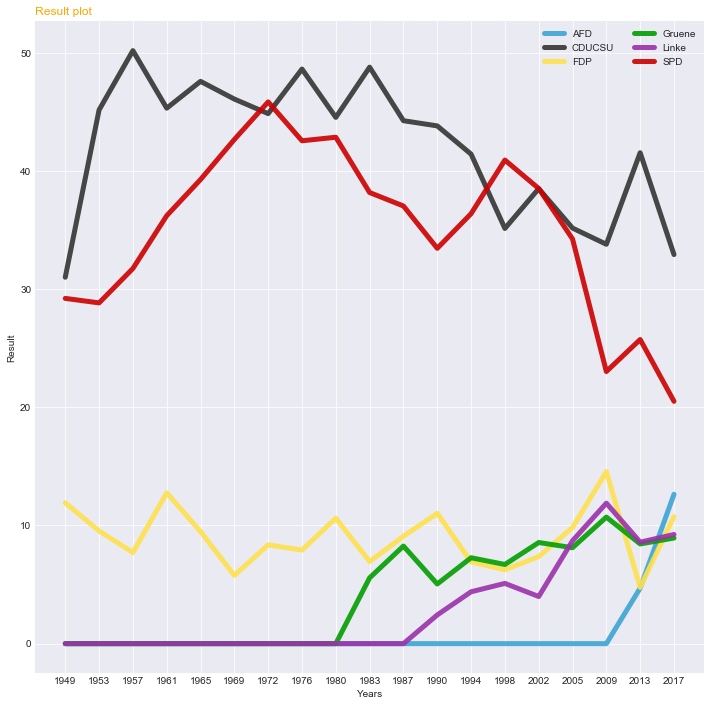

In [17]:
def plot_results(result_df):
    # style
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(12,12))
    # create a color palette
    palette = plt.get_cmap('Set1')

    # multiple line plot
    for column in result_df:
        plt.plot(result_df.index, result_df[column], marker='', color=color_of(column), linewidth=5, alpha=0.9, label=column)

    # Add legend
    plt.legend(loc=1, ncol=2)

    # Add titles
    plt.title("Result plot", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Years")
    plt.ylabel("Result")

plot_results(result_df)

D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWar

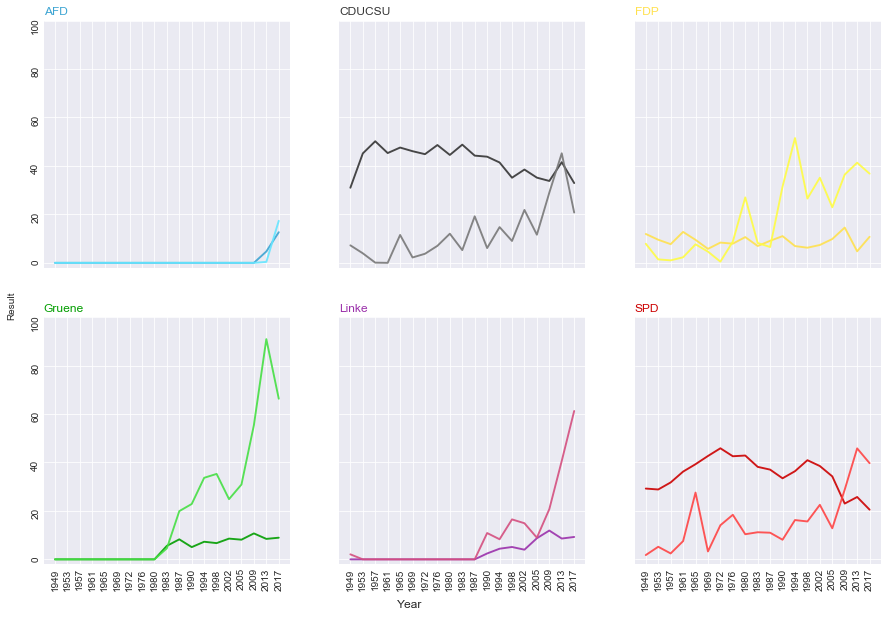

In [18]:
def plot_results_with_readability(result_df,readability_df):
    # Initialize the figure
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,10))
    # multiple line plot
    num=0
    for column in result_df:
        num+=1

        # Find the right spot on the plot
        plt.subplot(2,3, num)

        # Plot the lineplot
        plt.plot(result_df.index, result_df[column], marker='', color=color_of(column), linewidth=1.9, alpha=0.9, label=column)
        plt.plot(readability_df.index, readability_df[column], marker='', color=brighter_color_of(column), linewidth=1.9, alpha=0.9, label=column)


        #plt.xlim(0,)
        plt.ylim(-2,100)
        plt.tick_params(labelrotation=90)
        # Not ticks everywhere
        if num in [1,2,3] :
            plt.tick_params(labelbottom='off')
        if num not in [1,4] :
            plt.tick_params(labelleft='off')

        # Add title
        plt.title(column, loc='left', fontsize=12, fontweight=0, color=color_of(column) )
    # general title
    plt.suptitle('', fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

    # Axis title
    plt.text(-20, -20, 'Year',fontsize=12)
    plt.text(-51, 105, 'Result', ha='center', va='center', rotation='vertical')

#FRE - Readability
plot_results_with_readability(result_df,readability_df)

D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
D:\Anaconda\envs\stdenv\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWar

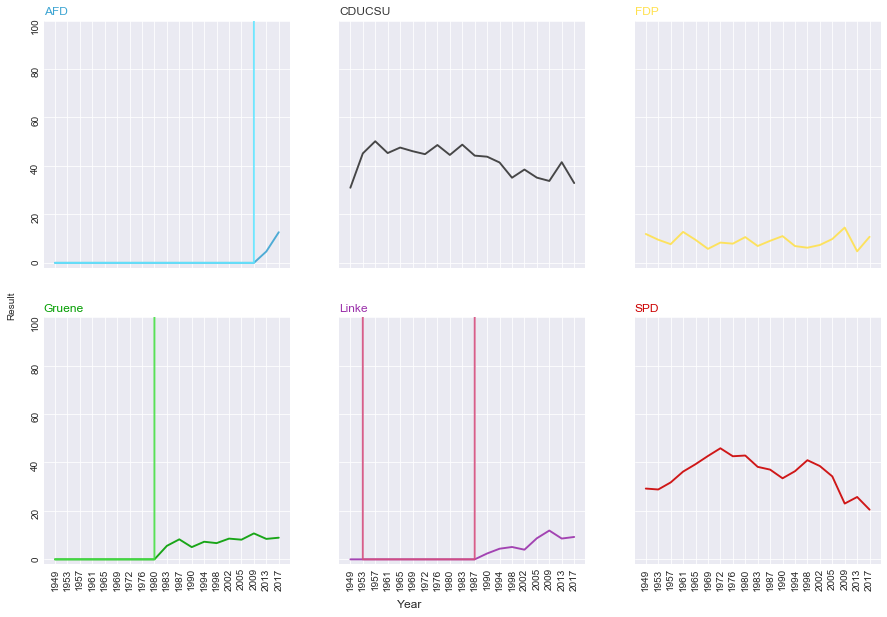

In [19]:
# word lenghts
plot_results_with_readability(result_df,df_from_readability_and_index(word_lengths,index))

# ------------------------------------------------------
# TF-IDF, Vector Space, Dimension Reduction

In [29]:
vectorized_df=vectorize(docs_filtered,index,tfidf=True)
vectorized_df.head()

00  000  001  004   01  0190er   03  044  048  050  ...  \
1949|CDUCSU  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1949|FDP     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1949|Linke   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1949|SPD     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1953|CDUCSU  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   

             übrigen  übung  übungsgelände  übungskapazitäten  übungsleiter  \
1949|CDUCSU      0.0    0.0            0.0                0.0           0.0   
1949|FDP         0.0    0.0            0.0                0.0           0.0   
1949|Linke       0.0    0.0            0.0                0.0           0.0   
1949|SPD         0.0    0.0            0.0                0.0           0.0   
1953|CDUCSU      0.0    0.0            0.0                0.0           0.0   

             übungsleitern  übungsleiterpauschale  übungsplätze  \
1949|CDUCSU            0.0                    0.0           0.0   
1949|FDP               0.0                    0.0           0.0   
1949|Linke             0.0                    0.0           0.0   
1949|SPD               0.0                    0.0           0.0   
1953|CDUCSU            0.0                    0.0           0.0   

             übungsstätten  üö0  
1949|CDUCSU            0.0  0.0  
1949|FDP               0.0  0.0  
1949|Linke             0.0  0.0  
1949|SPD               0.0  0.0  
1953|CDUCSU            0.0  0.0  

[5 rows x 59192 columns]

In [30]:
interesting_word_lists=get_n_max_words(vectorized_df,n=100)
interesting_words=extract_interesting_word_from_lists(interesting_word_lists)
interesting_words[:10]

['privatisierung',
 'karl',
 'anstreben',
 'gender',
 'vernünftig',
 'beihilfe',
 'zwang',
 'diplom',
 'kleinbauerntums',
 'verteidigungshaushalt']

In [31]:
vectorized_df[interesting_words].head()

privatisierung  karl  anstreben  gender  vernünftig  beihilfe  \
1949|CDUCSU             0.0   0.0   0.007144     0.0    0.000000  0.011085   
1949|FDP                0.0   0.0   0.000000     0.0    0.016775  0.008925   
1949|Linke              0.0   0.0   0.012832     0.0    0.000000  0.000000   
1949|SPD                0.0   0.0   0.000000     0.0    0.000000  0.000000   
1953|CDUCSU             0.0   0.0   0.000000     0.0    0.000000  0.000000   

                zwang  diplom  kleinbauerntums  verteidigungshaushalt  ...  \
1949|CDUCSU  0.000000     0.0              0.0                    0.0  ...   
1949|FDP     0.015263     0.0              0.0                    0.0  ...   
1949|Linke   0.000000     0.0              0.0                    0.0  ...   
1949|SPD     0.000000     0.0              0.0                    0.0  ...   
1953|CDUCSU  0.043323     0.0              0.0                    0.0  ...   

             wirtschaft  jahrzehnt  norden  bedingung  rechtsreformen  \
1949|CDUCSU    0.132950   0.000000     0.0   0.000000             0.0   
1949|FDP       0.011468   0.005013     0.0   0.008573             0.0   
1949|Linke     0.051174   0.000000     0.0   0.000000             0.0   
1949|SPD       0.073000   0.000000     0.0   0.000000             0.0   
1953|CDUCSU    0.086805   0.000000     0.0   0.000000             0.0   

             schuldenkrise  dynamisierung  ausbildung  veränderung  \
1949|CDUCSU            0.0            0.0    0.005124     0.000000   
1949|FDP               0.0            0.0    0.004125     0.004947   
1949|Linke             0.0            0.0    0.009204     0.000000   
1949|SPD               0.0            0.0    0.000000     0.000000   
1953|CDUCSU            0.0            0.0    0.015613     0.000000   

             wanderungsdruck  
1949|CDUCSU              0.0  
1949|FDP                 0.0  
1949|Linke               0.0  
1949|SPD                 0.0  
1953|CDUCSU              0.0  

[5 rows x 2598 columns]

## D3 Dataframes

In [32]:
def get_specific_docs(docs,specificities):
    set_specificities=sorted(set(specificities))
    
    specificity_docs=[]
    for specificity in set_specificities:
        specificity_doc=''
        for doc, doc_specificity in zip(docs,specificities):
            if specificity==doc_specificity:
                specificity_doc+=doc+'\n'
            
        specificity_docs.append(specificity_doc)
    
    #print(len(specificity_docs))
    return specificity_docs

def get_docs_for_one_year(docs,years,given_year):
    result_docs=[]
    for doc, year in zip(docs,years):
            if year==given_year:
                result_docs.append(doc)
            
    return result_docs

def get_partys_for_one_year(partys,years,given_year):
    res_partys=[]
    for party,year in zip(partys,years):
        if year==given_year:
            res_partys.append(party)
            
    return res_partys
    

def get_scores_for_word_and_year(vectorized_years_df,word,year):
    return vectorized_years_df[word].loc[year]

def get_year_specificities_dict(docs,years,partys):
    years_dict={}
    years_set=sorted(set(years))
    for year in years_set:
        relevant_partys=get_partys_for_one_year(partys,years,year)
        v_df=vectorize(get_docs_for_one_year(docs,years,year),relevant_partys)
        years_dict[year]=v_df
    return years_dict

def get_dominant_party_for_word_and_year(years_dict,word,year):
    try:
        year_df=years_dict[year][word]
        dominant_party=year_df.idxmax()
    except KeyError:
        dominant_party='None'
    
    return dominant_party

In [33]:
years=df.loc[df['type'] == 'b']['year']
partys=df.loc[df['type'] == 'b']['party_name']
vectorized_years_df=vectorize(get_specific_docs(docs_filtered,years),sorted(set(years)),tfidf=True)
vectorized_partys_df=vectorize(get_specific_docs(docs_filtered,partys),sorted(set(partys)),tfidf=True)
vectorized_years_df.head()

00  000  001  004   01  0190er   03  044  048  050  ...  übrigen  \
1949  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...      0.0   
1953  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...      0.0   
1957  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...      0.0   
1961  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...      0.0   
1965  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...      0.0   

      übung  übungsgelände  übungskapazitäten  übungsleiter  übungsleitern  \
1949    0.0            0.0                0.0           0.0            0.0   
1953    0.0            0.0                0.0           0.0            0.0   
1957    0.0            0.0                0.0           0.0            0.0   
1961    0.0            0.0                0.0           0.0            0.0   
1965    0.0            0.0                0.0           0.0            0.0   

      übungsleiterpauschale  übungsplätze  übungsstätten  üö0  
1949                    0.0           0.0       0.000000  0.0  
1953                    0.0           0.0       0.000000  0.0  
1957                    0.0           0.0       0.000000  0.0  
1961                    0.0           0.0       0.000000  0.0  
1965                    0.0           0.0       0.004442  0.0  

[5 rows x 59192 columns]

In [34]:
years_dict=get_year_specificities_dict(docs_filtered,years,partys)

In [35]:
def create_word_party_dict():
    dic={}
    working_df=vectorized_partys_df.transpose()
    for word, party in zip(working_df.index, working_df.idxmax(axis=1)):
        dic[word]=party
    return dic

word_party_dict=create_word_party_dict()

In [ ]:
words_csv(dim_reduction_words(vectorized_partys_df[extract_interesting_word_from_lists(get_n_max_words(vectorized_partys_df,n=100))].transpose(),method='TSNE'))

dim1       dim2               label    color  \
politik             10.881593 -11.685931             politik  #343434   
geben                3.905367  -3.243304               geben  #ffe800   
international        5.760473  -7.235308       international  #ffe800   
gerecht              1.500757  -6.535491             gerecht  #cc0000   
milliarde           -5.692577   7.016629           milliarde  #900C3F   
treten              -2.115359   1.670005              treten  #343434   
jugendliche         -5.905381   2.765785         jugendliche  #029e00   
verstärken           0.785652  -0.681083          verstärken  #ffe800   
vergleiche         -11.682294   6.236806          vergleiche  #900C3F   
ermöglichen          5.133604  -5.067860         ermöglichen  #ffe800   
gemeinsam            6.046774  -9.161831           gemeinsam  #cc0000   
000                 -8.027925  11.609896                 000  #21a1ff   
erhalten            10.387053  -7.991804            erhalten  #21a1ff   
setzen              12.299878 -11.529161              setzen  #029e00   
beenden             -5.441857  10.021390             beenden  #21a1ff   
infrastruktur       -5.221884   7.050606       infrastruktur  #900C3F   
interesse            7.169830  -4.267668           interesse  #cc0000   
million             -5.233690   1.556143             million  #900C3F   
deutlich            -5.000228   3.134528            deutlich  #029e00   
behinderung         -9.601290   4.382151         behinderung  #900C3F   
pflege              -8.525526   3.861378              pflege  #900C3F   
welt                 3.441039  -5.491637                welt  #343434   
wettbewerb          -1.506881  -3.974871          wettbewerb  #ffe800   
sozialdemokratisch   3.808763   4.259157  sozialdemokratisch  #cc0000   
wirtschaftlich       7.503293 -10.463436      wirtschaftlich  #343434   
mein                 7.946645 -11.487659                mein  #343434   
islam               -8.694771  14.719295               islam  #21a1ff   
ausbildung          -2.194059  -0.643989          ausbildung  #ffe800   
eltern              -3.464197   8.093739              eltern  #21a1ff   
ddr                -10.220077   4.904350                 ddr  #900C3F   
...                       ...        ...                 ...      ...   
derzeit             -8.468262  12.820321             derzeit  #21a1ff   
bereich              5.392606  -4.656188             bereich  #ffe800   
schutz               5.928410  -5.278473              schutz  #029e00   
zukunft              7.862813 -10.622604             zukunft  #343434   
weg                  3.583962  -4.927021                 weg  #cc0000   
freiheit             3.911940  -7.968401            freiheit  #ffe800   
aufgeben             0.753883   0.004914            aufgeben  #cc0000   
und                 -4.141388  -3.746413                 und  #343434   
beschäftigte       -11.150520   3.555824        beschäftigte  #900C3F   
90                   0.196498  10.963727                  90  #029e00   
sozial              10.669294 -14.616533              sozial  #900C3F   
fdp                  6.556524  -1.057491                 fdp  #ffe800   
grünen               0.957933  11.151632              grünen  #029e00   
bleiben              7.854019  -9.909976             bleiben  #343434   
sicherung            1.394334   0.762494           sicherung  #cc0000   
ehe                 -8.002565  12.868921                 ehe  #21a1ff   
linke              -11.627882   2.114647               linke  #900C3F   
türkei              -8.169566  13.456200              türkei  #21a1ff   
erfolgreich          1.746735   2.333618         erfolgreich  #343434   
gewerkschaft       -10.269963   6.102466        gewerkschaft  #900C3F   
regelung            -3.163906  -2.181324            regelung  #ffe800   
stärken             10.805687 -11.443784             stärken  #029e00   
stehen               8.818706  -9.417784              stehen  #343434   
sichern   

In [36]:
def parse_json_manifesto(json_file_name,add=''):
    parties, party_dict=get_json_parties()
    bubbles=[]
    with open(json_file_name+'.json') as json_file:
        elements = json.load(json_file)
        for element in elements:
            bubble={}
            bubble['party']=party_dict[element['party']]
            bubble['year']=int(element['year'])
            bubble['size']=element['size']
            bubble['fontSize']=element['fontsize']
            bubble['x']={'umap':element['dim11'],'tsne':element['dim21'],'pca':element['dim31']}
            bubble['y']={'umap':element['dim12'],'tsne':element['dim22'],'pca':element['dim32']}

            bubbles.append(bubble)

    json_obj={'parties':parties,'bubbles':bubbles}
    #json.dumps(json_obj, indent=4)

    with open(json_file_name+add+'.json', 'w') as outfile:  
        json.dump(json_obj, outfile,indent=4)
        
def parse_json_manifesto_n(json_file_name,add=''):
    years_set=sorted(set(years))
    parties, party_dict=get_json_parties()
    bubbles=[]
    with open(json_file_name+'.json') as json_file:
        elements = json.load(json_file)
        for element in elements:
            bubble={}
            bubble['label']=int(element['year'])
            bubble['dominantParty']=party_dict[element['party']]
            bubble['x']={'umap':element['dim11'],'tsne':element['dim21'],'pca':element['dim31']}
            bubble['y']={'umap':element['dim12'],'tsne':element['dim22'],'pca':element['dim32']}

            years_dict_size={}
            years_dict_party={}
            for year in years_set:
                years_dict_size[year]=element['size']
                
                party=party_dict[element['party']]
                if party!='None':
                    years_dict_party[year]=party
                else:
                    years_dict_party[year]='none'
                
                
            #bubble['year']=int(element['year'])
            bubble['size']=years_dict_size
            bubble['party']=years_dict_party
            #bubble['fontSize']=element['fontsize']

            bubbles.append(bubble)

    json_obj={'parties':parties,'bubbles':bubbles}
    #json.dumps(json_obj, indent=4)

    with open(json_file_name+add+'.json', 'w') as outfile:  
        json.dump(json_obj, outfile,indent=4)
        
def parse_json_time(json_file_name,years,add=''):
    years_set=sorted(set(years))
    parties, party_dict=get_json_parties()
    bubbles=[]
    with open(json_file_name+'.json') as json_file:
        elements = json.load(json_file)
        for element in elements:
            bubble={}
            bubble['label']=element['label']
            bubble['dominantParty']=party_dict[element['party']]
            bubble['x']={'umap':element['dim11'],'tsne':element['dim21'],'pca':element['dim31']}
            bubble['y']={'umap':element['dim12'],'tsne':element['dim22'],'pca':element['dim32']}
            
            years_dict_size={}
            years_dict_party={}
            for year in years_set:
                years_dict_size[year]=element['size_'+year]
                
                party=element['party_'+year]
                if party!='None':
                    years_dict_party[year]=party_dict[party]
                else:
                    years_dict_party[year]='none'
                
                
            #bubble['year']=int(element['year'])
            bubble['size']=years_dict_size
            bubble['party']=years_dict_party
            #bubble['fontSize']=element['fontsize']

            bubbles.append(bubble)

    json_obj={'parties':parties,'bubbles':bubbles}
    #json.dumps(json_obj, indent=4)

    with open(json_file_name+add+'.json', 'w') as outfile:  
        json.dump(json_obj, outfile,indent=4)

In [ ]:
temp_df=vectorized_partys_df[extract_interesting_word_from_lists(get_n_max_words(vectorized_partys_df,n=100))].transpose()
principial_dfs=[]
principial_dfs.append(dim_reduction_words(vectorized_df,method='TSNE'))
principial_dfs.append(dim_reduction_words(vectorized_df,method='UMAP'))
principial_dfs.append(dim_reduction_words(vectorized_df,method='PCA'))
manifesto_csv_m(principial_dfs).to_json('manifesto_bubbles.json',orient='records')
parse_json_manifesto_n('manifesto_bubbles')

In [ ]:
temp_df=vectorized_partys_df[extract_interesting_word_from_lists(get_n_max_words(vectorized_partys_df,n=100))].transpose()
principial_dfs=[]
principial_dfs.append(dim_reduction_words(temp_df,method='TSNE'))
principial_dfs.append(dim_reduction_words(temp_df,method='UMAP'))
principial_dfs.append(dim_reduction_words(temp_df,method='PCA'))
words_csv_m(principial_dfs).to_json('src/D3/word_bubbles.json',orient='records')

In [72]:
n=15
manuells=['natur','umwelt','klima','umweltschutz']
interesting_words_all=extract_interesting_word_from_lists(get_n_max_words(vectorized_df,n=n))
interesting_words_all.extend(extract_interesting_word_from_lists(get_n_max_words(vectorized_partys_df,n=n)))
interesting_words_all.extend(extract_interesting_word_from_lists(get_n_max_words(vectorized_years_df,n=n)))
interesting_words_all=sorted(set(interesting_words_all))
interesting_words_all.extend(manuells)
interesting_words_all
import re
regex=re.compile('.*\d.*',re.IGNORECASE)
interesting_words_all=sorted([word for word in interesting_words_all if not regex.match(word)])


interesting_words_all

['ableisten',
 'abschaffen',
 'abtretung',
 'adenauer',
 'afd',
 'aktionsprogramm',
 'alleinherrschaft',
 'alliierte',
 'anleh',
 'arbeit',
 'arbeitnehmer',
 'arbeitnehmerinnen',
 'arbeitsplätze',
 'artikel',
 'aufbau',
 'aufgebaut',
 'aufstieg',
 'ausbau',
 'ausführlich',
 'ausgrenzung',
 'bauer',
 'bauerntum',
 'bedrückungen',
 'beherr',
 'behinderung',
 'beispiel',
 'bereich',
 'berücksichti',
 'besatzungskosten',
 'besatzungstruppen',
 'beschäftigte',
 'beständigkeit',
 'bildung',
 'bildungsaufgaben',
 'bildungsforschung',
 'bildungsplanung',
 'bildungswesens',
 'bind',
 'bisherig',
 'bitten',
 'bißchen',
 'bleiben',
 'blo',
 'brandt',
 'brauchen',
 'brd',
 'buchstabe',
 'bund',
 'bundesgewalt',
 'bundeskanzler',
 'bundesländern',
 'bundesregierung',
 'bundesrepublik',
 'bzw',
 'bündnis',
 'bür',
 'bürgergeld',
 'bürgergesellschaft',
 'bürgerin',
 'bürgerinnen',
 'bürgern',
 'büßen',
 'cdu',
 'chance',
 'christlich',
 'christlichdemokratische',
 'christlichdemokratischen',
 'csu',


In [73]:
random_state=9
temp_df=vectorized_partys_df[interesting_words_all].transpose()
principial_dfs=[]
principial_dfs.append(dim_reduction_words(temp_df,method='TSNE',random_state=random_state))
principial_dfs.append(dim_reduction_words(temp_df,method='UMAP',random_state=random_state))
principial_dfs.append(dim_reduction_words(temp_df,method='PCA',random_state=random_state))
words_csv_years(principial_dfs).to_json('src/D3/bubbles/time_bubbles_1.json',orient='records')
parse_json_time('src/D3/bubbles/time_bubbles_1',years,'')

In [ ]:
#vectorized_years_df[extract_interesting_word_from_lists(get_n_max_words(vectorized_years_df,n=100))]

In [30]:
test_df=vectorized_df[interesting_words]

## Matplotlib Charts

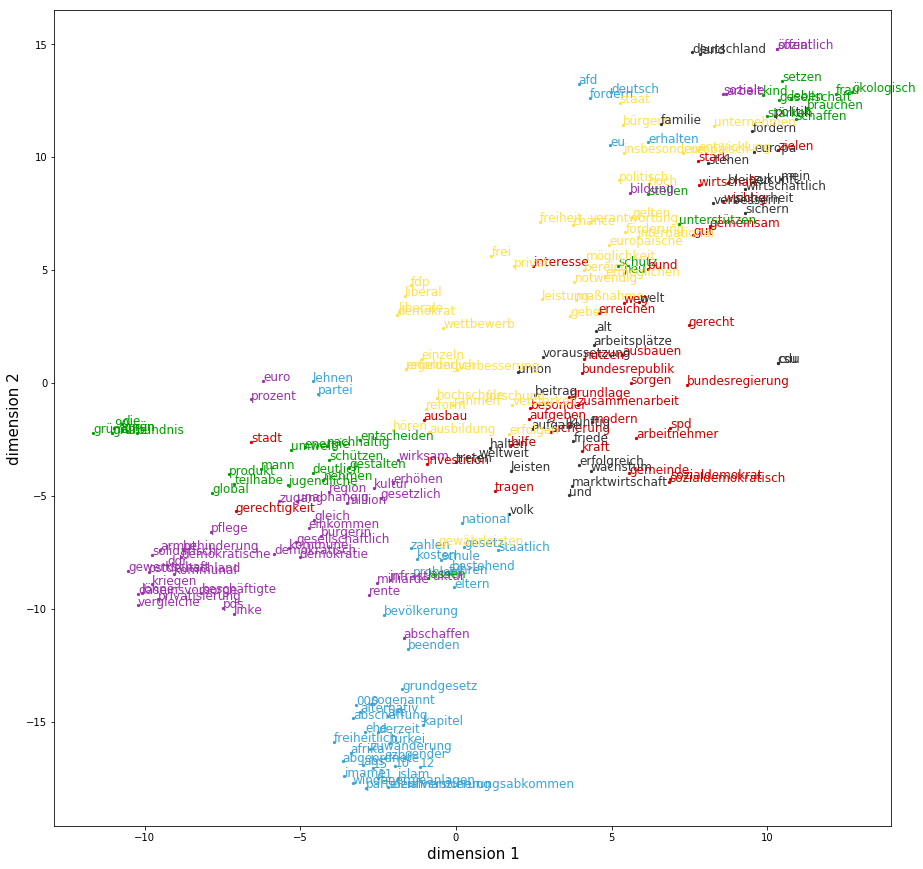

In [61]:
plot_words(dim_reduction_words(vectorized_partys_df[extract_interesting_word_from_lists(get_n_max_words(vectorized_partys_df,n=100))].transpose(),method='TSNE'))

In [ ]:
plot_scatter_data(dim_reduction(vectorized_df,method='UMAP'))

In [ ]:
plot_scatter_data(dim_reduction(vectorized_df[interesting_words],method='UMAP'))

# experimental

In [ ]:
docs_tokenized=filter_stopwords_and_lemmatize(spacified,return_type='Token')

In [ ]:
def partyfy_docs(docs_tokenized):
    partified_docs=[]
    for doc in docs_tokenized:
        partified_doc=[]
        for token in doc:
            dominant_party=word_party_dict.get(token)
            if dominant_party is None:
                dominant_party='unknown'
            partified_doc.append((token,dominant_party))
        partified_docs.append(partified_doc)
    return partified_docs

partified_docs=partyfy_docs(docs_tokenized)

In [ ]:
def get_dominance_values(partified_docs,exclude_best=True):
    dominant_party_term_docs=[]
    for doc in partified_docs:
        counter=collections.OrderedDict(sorted(collections.Counter(x[1] for x in doc).items()))
        if exclude_best:
            counter.pop(max(counter, key=counter.get))
        dominant_party_term_docs.append(counter)
        
    return dominant_party_term_docs


def get_dominant_term_partys(dominant_party_term_docs):
    res=[]
    for dic in dominant_party_term_docs:
        res.append(max(dic, key=dic.get))
    return res

dominant_term_partys=get_dominant_term_partys(get_dominance_values(partified_docs))

In [ ]:
for idx, dom_party in zip(index[:10],dominant_term_partys[:10]):
    print(idx,dom_party)

# ------------------------------------------------------
# Topic Modelling

In [47]:
import gensim
import gensim.corpora as corpora
topic_number=10
id2word = corpora.Dictionary(docs_tokenized)

corpus = [id2word.doc2bow(text) for text in docs_tokenized]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic_number, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=20,
                                           alpha='auto',
                                           eta='auto',
                                           iterations=500,
                                           per_word_topics=True)

D:\Anaconda\envs\stdenv\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
D:\Anaconda\envs\stdenv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


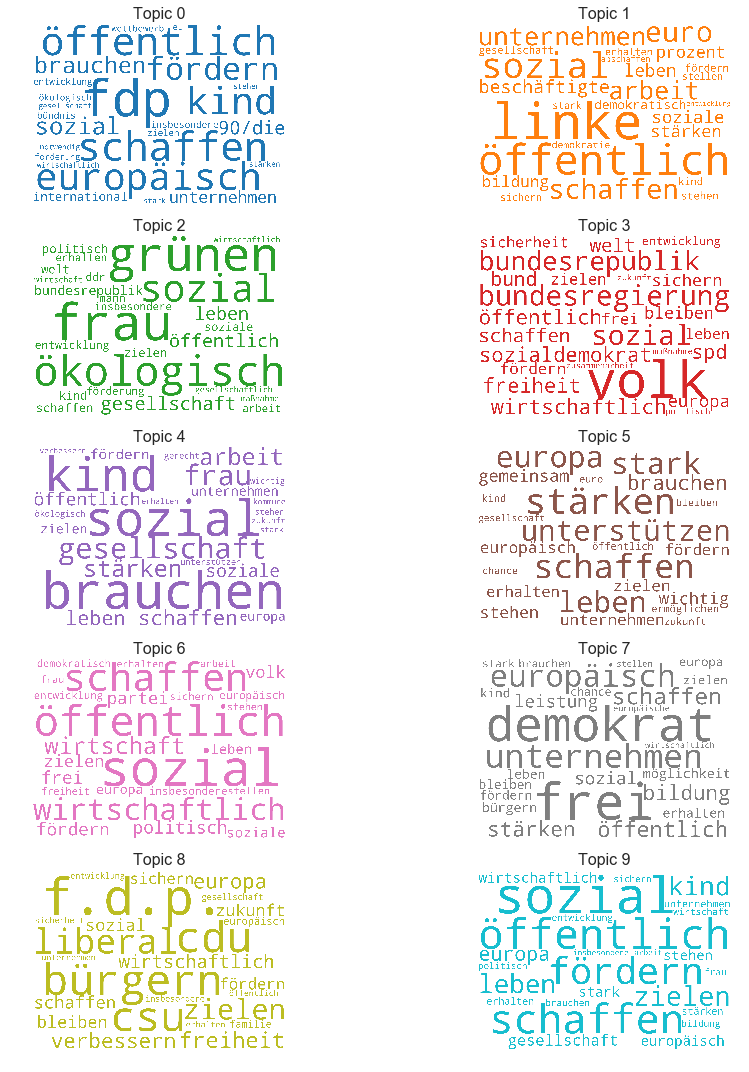

In [52]:
import matplotlib.colors as mcolors

def topic_clouds(lda_model):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    stop_words = list(spacy.lang.de.stop_words.STOP_WORDS)
    stop_words.extend(['deutschland','setzen','land','deutsch','politik','staat','fordern'])

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=25,
                      colormap='Paired',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False,num_words=50)

    fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])

        for stop_word in stop_words:
            if stop_word in topic_words.keys():
                topic_words.pop(stop_word)
        cloud.generate_from_frequencies(topic_words, max_font_size=500)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    
topic_clouds(lda_model)

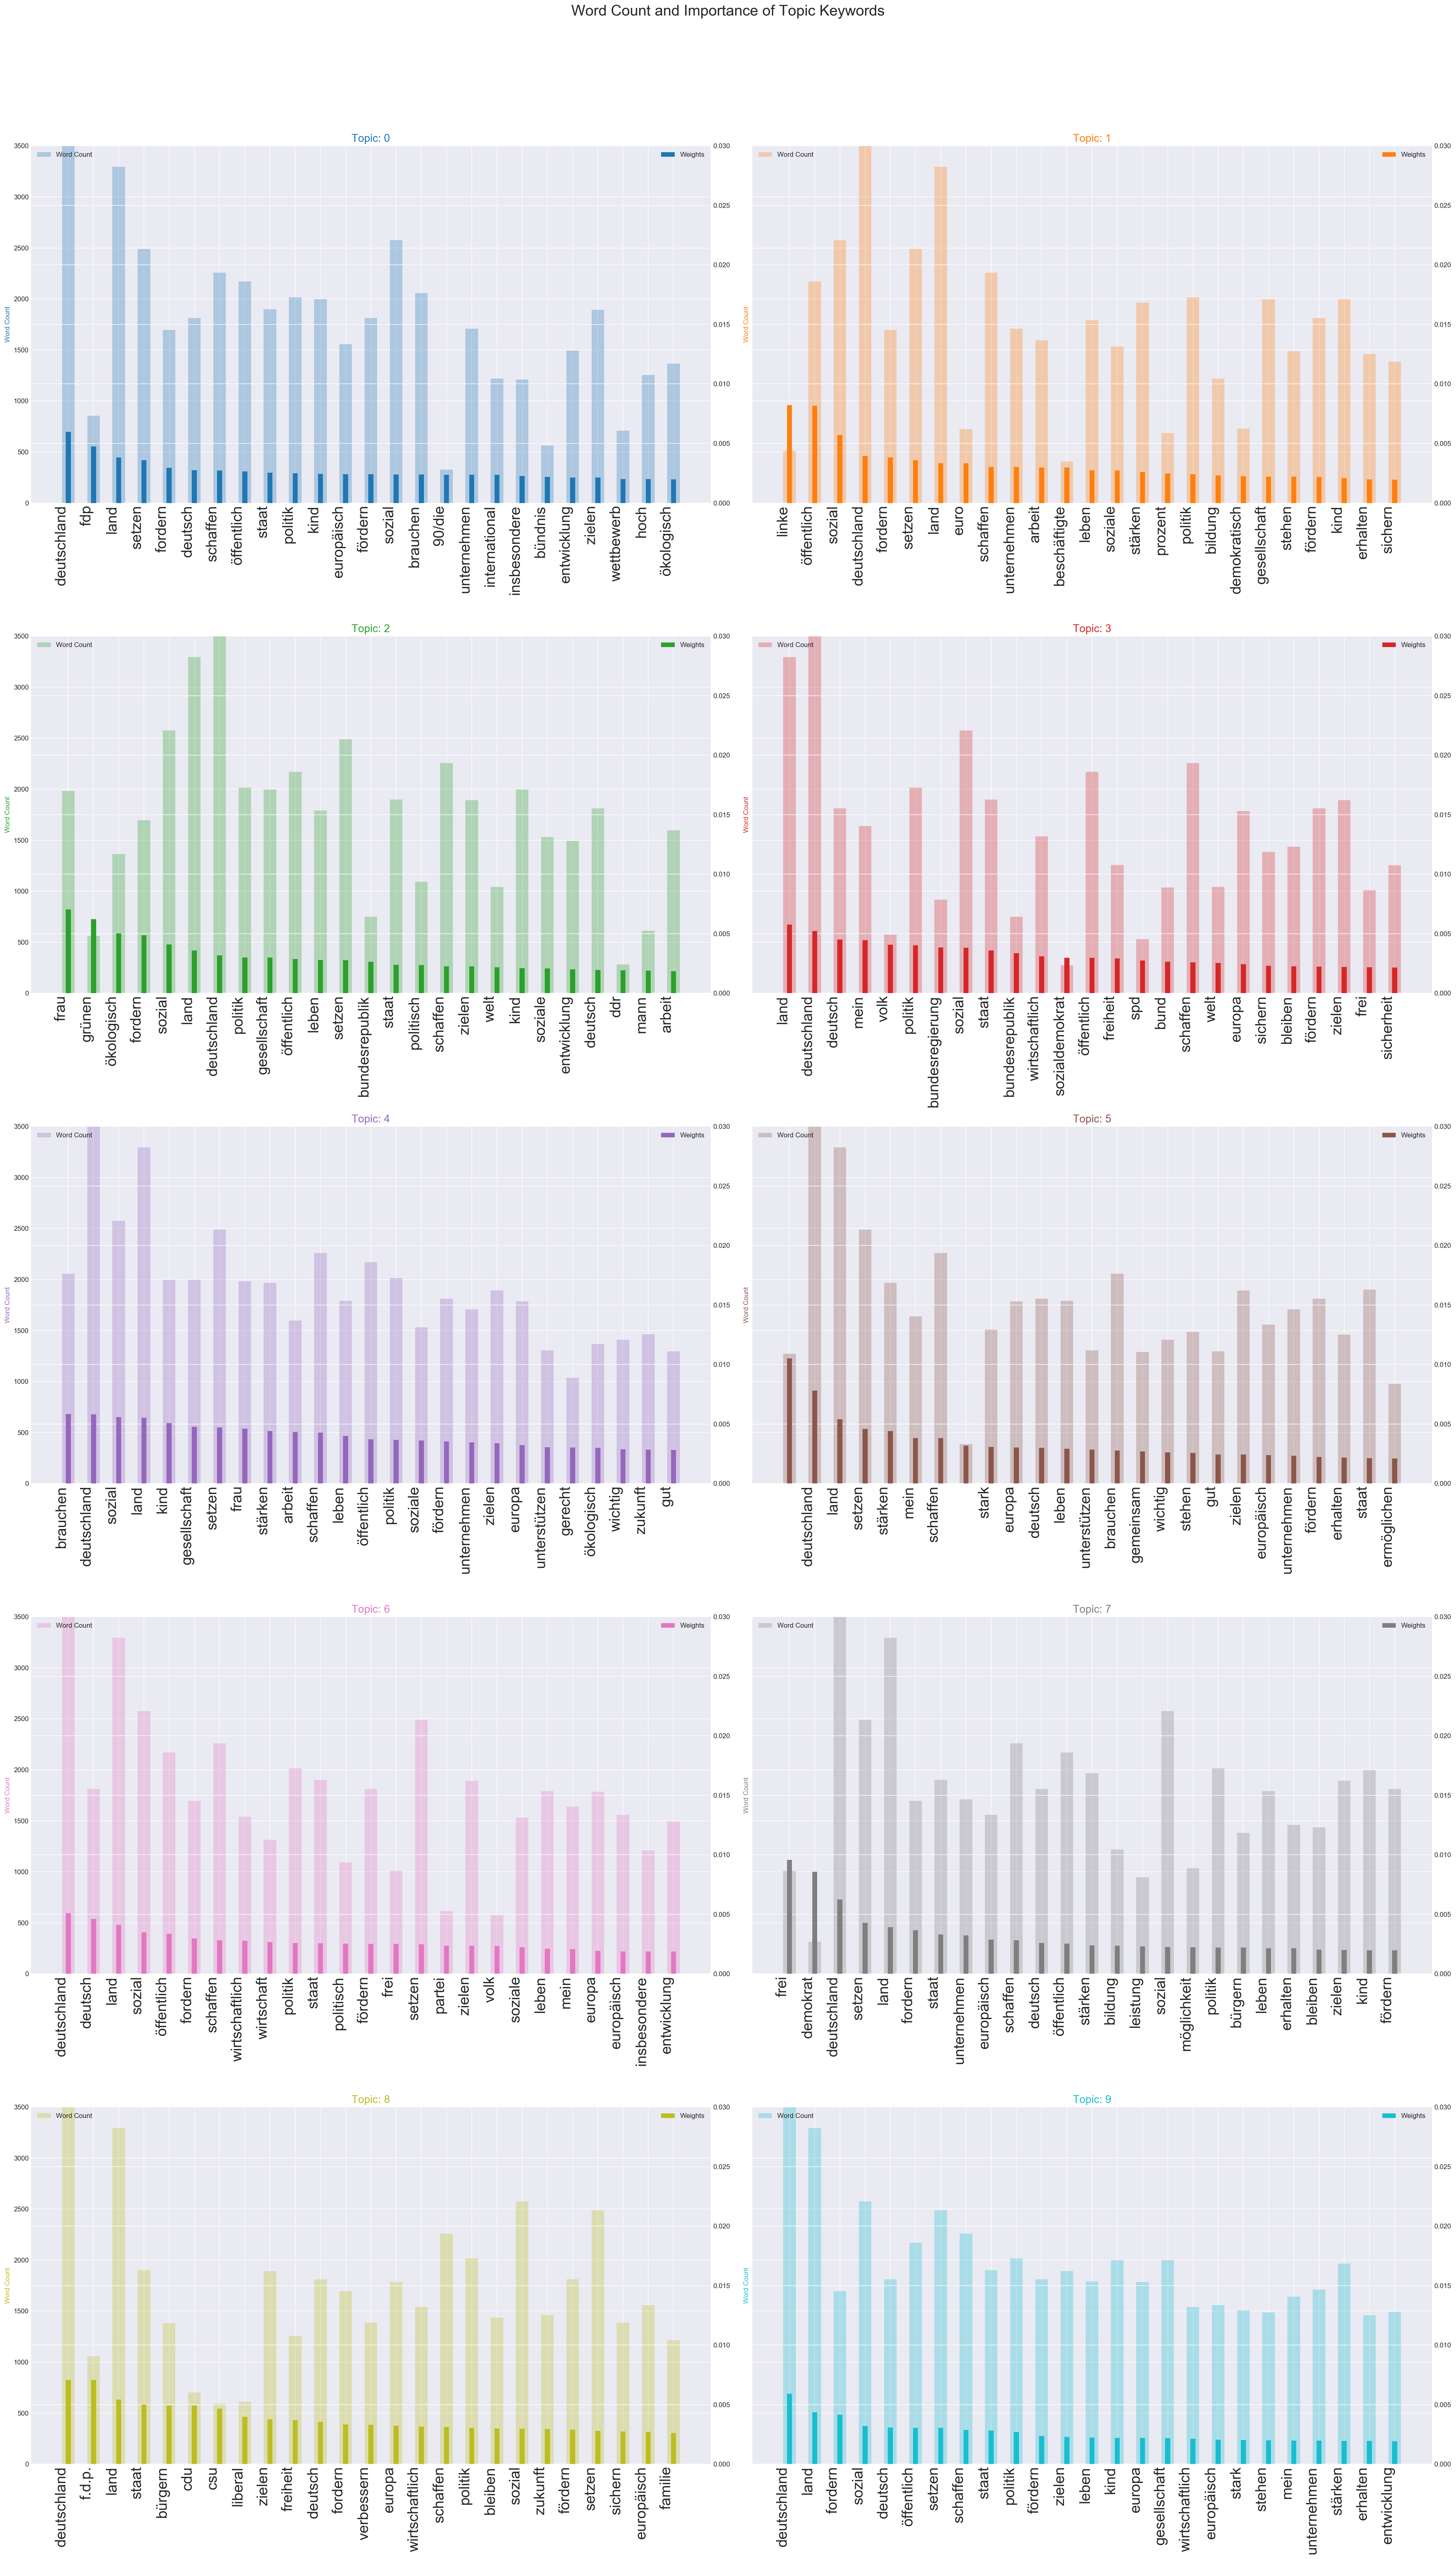

In [54]:
def topic_bars(lda_model,docs_tokenized):
    topics = lda_model.show_topics(formatted=False,num_words=25)
    data_flat = [w for w_list in docs_tokenized for w in w_list]
    counter = collections.Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    fig, axes = plt.subplots(5, 2, figsize=(30,50), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=90, horizontalalignment= 'right',fontsize=22)
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()
    
    #return df
    
topic_bars(lda_model,docs_tokenized)

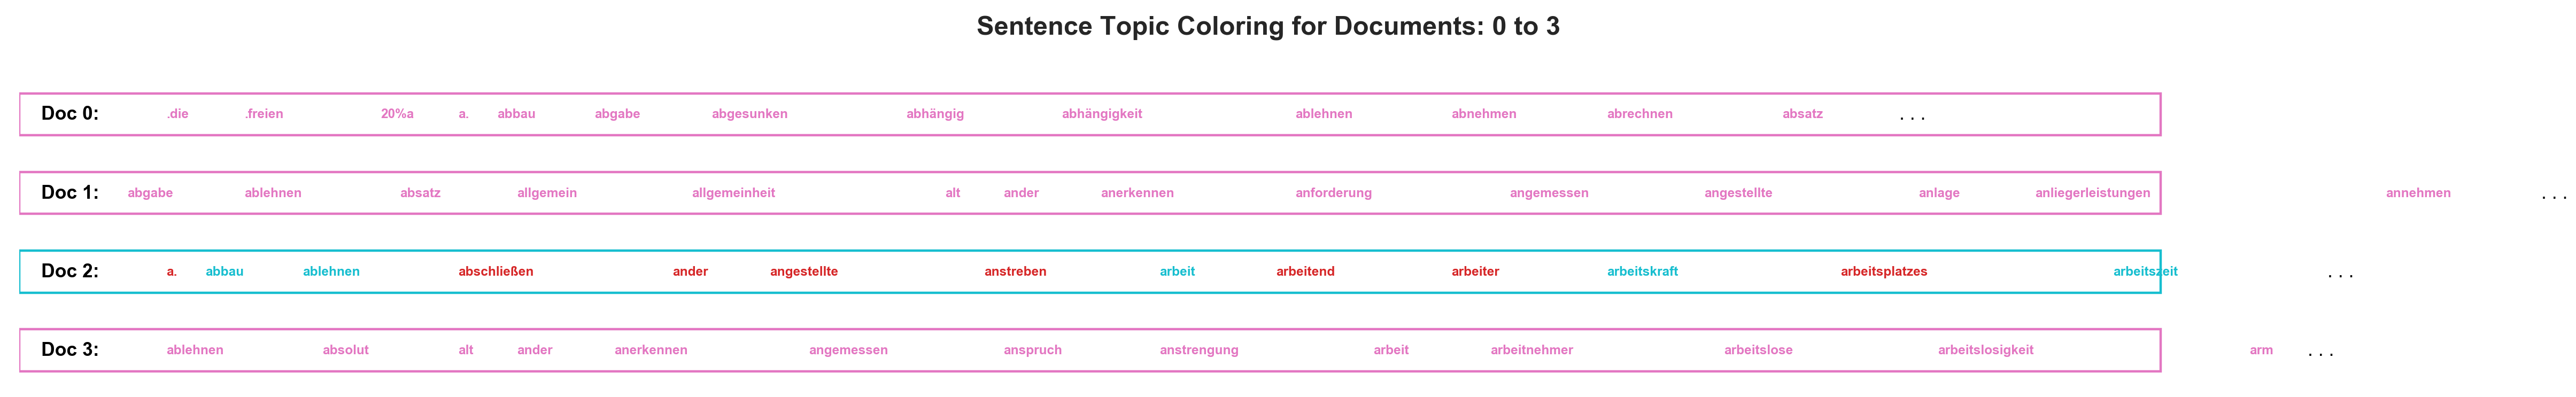

In [55]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 5):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(30, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.05
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=11, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()


# ------------------------------------------------------
# Wordclouds

In [28]:
def word_cloud(df,party,year):
    tfidf_dict=(df.transpose()[f'{year}|{party}']+0.00001).to_dict()
    wordcloud = WordCloud(background_color=color_of(party)).generate_from_frequencies(tfidf_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def result_words_df(df,year):

    results=[]
    columns=[]
    for party in partys:
        results.append(get_election_result('2017',party))
        columns.append(f'{year}|{party}')
    
    
    computed_df=(df.transpose()[columns]*np.array(results)).transpose()
    computed_df=(computed_df/computed_df.sum(axis=0)).fillna(0)
    return computed_df

result_words_df(vectorized_df[interesting_words],'2017').head()

entschädigung    halten  weu  ersehnen  verkehrsvertrag  gern  \
2017|CDUCSU       0.000000  0.029487  0.0       0.0              0.0   0.0   
2017|FDP          0.000000  0.007712  0.0       0.0              0.0   0.0   
2017|Linke        0.036139  0.003021  0.0       0.0              0.0   0.0   
2017|SPD          0.000000  0.009459  0.0       0.0              0.0   0.0   
2017|CDUCSU       0.000000  0.029487  0.0       0.0              0.0   0.0   

             ausbildungsweges  finanzplanung  geschichtlich  entscheiden  ...  \
2017|CDUCSU               0.0       0.000000            0.0     0.017064  ...   
2017|FDP                  0.0       0.015241            0.0     0.008368  ...   
2017|Linke                0.0       0.000000            0.0     0.004807  ...   
2017|SPD                  0.0       0.037390            0.0     0.019706  ...   
2017|CDUCSU               0.0       0.000000            0.0     0.017064  ...   

             erscheinen  gesellschaftspolitischer  bürokratie  ökonomie  \
2017|CDUCSU    0.000000                       0.0    0.029316  0.000000   
2017|FDP       0.043889                       0.0    0.012267  0.000000   
2017|Linke     0.000000                       0.0    0.000501  0.073165   
2017|SPD       0.000000                       0.0    0.009404  0.000000   
2017|CDUCSU    0.000000                       0.0    0.029316  0.000000   

                heißt  leichtfertig      open  zuwenig  sdi  heimatlos  
2017|CDUCSU  0.000000           0.0  0.000000      0.0  0.0        0.0  
2017|FDP     0.000000           0.0  0.019970      0.0  0.0        0.0  
2017|Linke   0.111111           0.0  0.009126      0.0  0.0        0.0  
2017|SPD     0.000000           0.0  0.024495      0.0  0.0        0.0  
2017|CDUCSU  0.000000           0.0  0.000000      0.0  0.0        0.0  

[5 rows x 2598 columns]

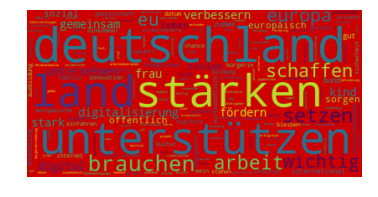

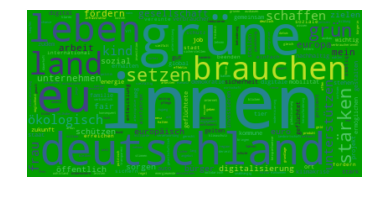

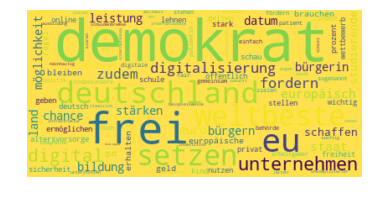

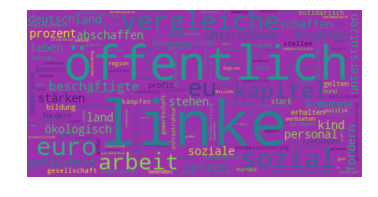

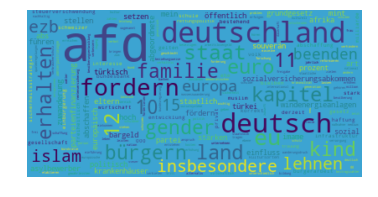

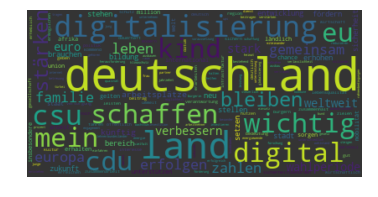

In [31]:
for party in set(partys):
    word_cloud(test_df,party,'2017')

In [20]:
#for party in partys:
#    word_cloud(result_words_df(vectorized_df[interesting_words],'2017'),party,'2017')

# ------------------------------------------------------
# Heatmaps, Piemaps

In [18]:
def heatmap(x, y, size,color,figsize):
    fig, ax = plt.subplots(figsize=figsize)
    fig
    # Mapping from column names to integer coordinates
    x_labels = x
    y_labels = y
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}
    
    x_scatter=[]
    y_scatter=[]
    for i, y_label in enumerate(y_labels):
        for j, x_label in enumerate(x_labels):
            x_scatter.append(j)
            y_scatter.append(i)
    
    size_scale = 500
    
    ax.scatter(
        x=x_scatter, # Use mapping for x
        y=y_scatter, # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color,
        marker='o' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])


In [19]:
def piemap(x, y, size,ratios,figsize):
    fig, ax = plt.subplots(figsize=figsize)
    fig
    # Mapping from column names to integer coordinates
    x_labels = x
    y_labels = y
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}
    
    x_scatter=[]
    y_scatter=[]
    for i, y_label in enumerate(y_labels):
        for j, x_label in enumerate(x_labels):
            x_scatter.append(j)
            y_scatter.append(i)
    
    colors=[color_of(party) for party in partys]

    for i,_ in enumerate(x_scatter):
        ax.pie(ratios[i], colors=colors,
               center=(x_scatter[i], y_scatter[i]), radius=size[i], frame=True)

    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])


In [20]:
test_df.head()

konjunkturpolitik       ehe  flüchtlingsproblem     zwang  \
1949|CDUCSU                0.0  0.000000            0.000000  0.000000   
1949|FDP                   0.0  0.000000            0.000000  0.015263   
1949|Linke                 0.0  0.000000            0.000000  0.000000   
1949|SPD                   0.0  0.000000            0.093899  0.000000   
1953|CDUCSU                0.0  0.010434            0.000000  0.043323   

             demokratischen  aus  deutschtands  klerikal  koalitionsaussage  \
1949|CDUCSU             0.0  0.0           0.0       0.0                0.0   
1949|FDP                0.0  0.0           0.0       0.0                0.0   
1949|Linke              0.0  0.0           0.0       0.0                0.0   
1949|SPD                0.0  0.0           0.0       0.0                0.0   
1953|CDUCSU             0.0  0.0           0.0       0.0                0.0   

                besat  ...  lebensstandards  denkende  ungeboren  behinderung  \
1949|CDUCSU  0.000000  ...         0.012166       0.0        0.0     0.000000   
1949|FDP     0.000000  ...         0.009795       0.0        0.0     0.000000   
1949|Linke   0.038397  ...         0.000000       0.0        0.0     0.000000   
1949|SPD     0.000000  ...         0.026720       0.0        0.0     0.000000   
1953|CDUCSU  0.000000  ...         0.055603       0.0        0.0     0.022728   

             schweigen  familienheimen  bedeutung   vn  agrarpolitik  \
1949|CDUCSU        0.0        0.000000   0.021027  0.0      0.000000   
1949|FDP           0.0        0.000000   0.004232  0.0      0.000000   
1949|Linke         0.0        0.000000   0.000000  0.0      0.000000   
1949|SPD           0.0        0.000000   0.000000  0.0      0.000000   
1953|CDUCSU        0.0        0.065133   0.016017  0.0      0.010012   

             bestehend  
1949|CDUCSU   0.021298  
1949|FDP      0.004287  
1949|Linke    0.000000  
1949|SPD      0.000000  
1953|CDUCSU   0.008112  

[5 rows x 2598 columns]

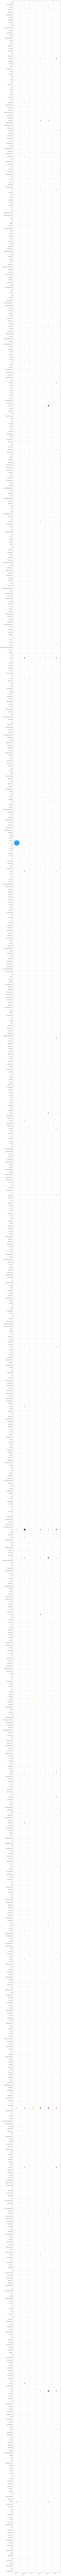

In [21]:
def plot_words_for_year(year,df,n=1000):
    colors=[]
    sizes=[]
    words=df.columns[:n]
    partys=sorted(set([index.split('|')[1] for index in df.index]))
    
    for i, y_label in enumerate(words):
        for j, party in enumerate(partys):
            colors.append(color_of(party))
            try:
                sizes.append((df[y_label][f'{year}|{party}']*100)**2)
            except KeyError:
                sizes.append(0)
    
    heatmap(
        x=pd.Series(partys),
        y=pd.Series(words),
        size=sizes,
        color=colors,
        figsize=(len(partys)*2,len(words)/1.5)
    )
    
plot_words_for_year('2017',test_df)

KeyboardInterrupt: 

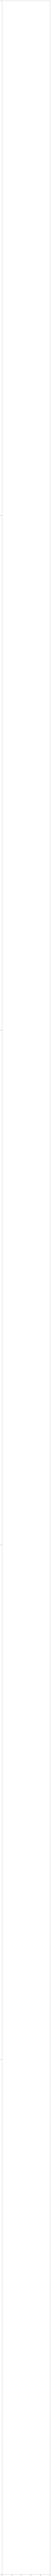

In [39]:
def plot_words_for_all_years(df,n=1000):
    colors=[]
    sizes=[]
    words=df.columns[:n]
    partys=sorted(set([index.split('|')[1] for index in df.index]))
    years=sorted(set([index.split('|')[0] for index in df.index]))
    
    for i, y_label in enumerate(words):
        for j, year in enumerate(years):
            summe=0
            max_party='AFD'
            max_value=0
            for k, party in enumerate(partys):
                try:
                    summand=df[y_label][f'{year}|{party}']

                    if summand>max_value:
                        max_value=summand
                        max_party=party

                    summe+=summand
                    max_party
                except KeyError:
                    summe+=0
            
            colors.append(color_of(max_party))
            sizes.append((summe*100)**2)
            
            

    heatmap(
        x=pd.Series(years),
        y=pd.Series(words),
        size=sizes,
        color=colors,
        figsize=(len(partys)*2,len(words)/1.5)
    )
    
plot_words_for_all_years(test_df)

D:\Anaconda\envs\stdenv\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


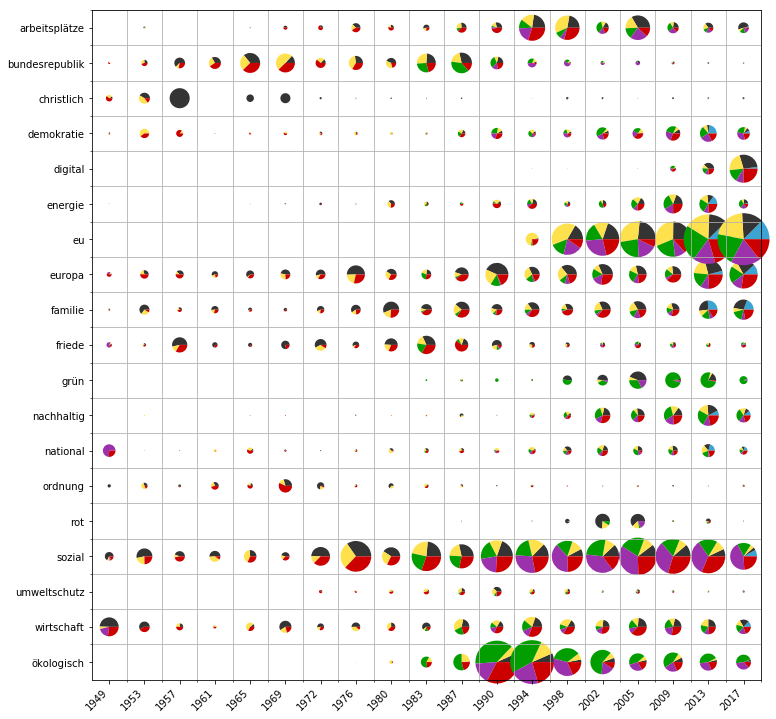

In [44]:
def plot_words_for_all_years(df,n=1000):
    colors=[]
    sizes=[]
    words=sorted(df.columns[:n],reverse=True)
    partys=sorted(set([index.split('|')[1] for index in df.index]))
    years=sorted(set([index.split('|')[0] for index in df.index]))
    ratios=[]
    for i, y_label in enumerate(words):
        
        for j, year in enumerate(years):
            summe=0
            max_party='AFD'
            max_value=0
            ratio=[]
            for k, party in enumerate(partys):
                try:
                    summand=df[y_label][f'{year}|{party}']

                    summe+=summand
                    ratio.append(summand)
                except KeyError:
                    summe+=0
                    ratio.append(0)
                    
            ratio=np.array(ratio)
            ratios.append(np.nan_to_num(ratio/ratio.sum()))
            sizes.append(summe)
            
    piemap(
        x=pd.Series(years),
        y=pd.Series(words),
        size=sizes,
        ratios=ratios,
        figsize=(len(partys)*2,len(words)/1.5)
    )
    
plot_words_for_all_years(vectorized_df[choosen_words])

In [25]:
choosen_words=['arbeitsmarkt','partei','ökologisch','wirtschaft','wirtschaftlich','wirtschaftskrise','verantwortung','generation','gut','schlecht','problem','demokratie','hoch','national','produkt','ordnung','privat','nachhaltig','umweltschutz','klima','kultur','digital','energie','friede','familie','militär','vaterland','kommune','heimat','modern','bundesrepublik','eigentum','alt','chance','grün','rot','erhalten','arbeitsplätze','demokratisch','christlich','islam','eu','europa','verbessern','sozial','heimatvertriebenen','fordern']

In [24]:
choosen_words=['arbeitsplätze','bundesrepublik','christlich','demokratie','digital','energie','europa','eu','familie','friede','nachhaltig','national','ordnung','sozial','umweltschutz','rot','grün','wirtschaft','ökologisch']

# Word based analysis

In [17]:
len(docs_filtered)

78

In [18]:
tfidf_df=vectorize(docs_filtered,index,tfidf=True)
freq_df=vectorize(docs_filtered,index,tfidf=False)
freq_df=freq_df.div(freq_df.sum(axis=1), axis=0)

In [19]:
freq_df.head()

00  000  001  004   01  0190er   03  044  048  050  ...  \
1949|CDUCSU  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1949|FDP     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1949|Linke   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1949|SPD     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   
1953|CDUCSU  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...   

             übrigen  übung  übungsgelände  übungskapazitäten  übungsleiter  \
1949|CDUCSU      0.0    0.0            0.0                0.0           0.0   
1949|FDP         0.0    0.0            0.0                0.0           0.0   
1949|Linke       0.0    0.0            0.0                0.0           0.0   
1949|SPD         0.0    0.0            0.0                0.0           0.0   
1953|CDUCSU      0.0    0.0            0.0                0.0           0.0   

             übungsleitern  übungsleiterpauschale  übungsplätze  \
1949|CDUCSU            0.0                    0.0           0.0   
1949|FDP               0.0                    0.0           0.0   
1949|Linke             0.0                    0.0           0.0   
1949|SPD               0.0                    0.0           0.0   
1953|CDUCSU            0.0                    0.0           0.0   

             übungsstätten  üö0  
1949|CDUCSU            0.0  0.0  
1949|FDP               0.0  0.0  
1949|Linke             0.0  0.0  
1949|SPD               0.0  0.0  
1953|CDUCSU            0.0  0.0  

[5 rows x 59192 columns]

In [20]:
from gensim.models import Word2Vec
# define training data
docs_tokenized=[doc.split() for doc in docs_filtered]
# train model
model = Word2Vec(docs_tokenized, size=100, window=5, min_count=1, workers=4, sg=1)
word_vectors = model.wv
# summarize vocabulary
#words = list(model.wv.vocab)
#print(words)
# access vector for one word
# save model
#model.save('model.bin')
# load model
#new_model = Word2Vec.load('model.bin')
#print(new_model)
def get_neighbors(word_vectors,word,topn=10):
    try:
        neighbors=word_vectors.most_similar(word.lower(),topn=10)
    except:
        neighbors=[]
    return [w for w,s in neighbors]

get_neighbors(word_vectors,'natur')

D:\Anaconda\envs\stdenv\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
D:\Anaconda\envs\stdenv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


['landschaft',
 'umwelt',
 'klima',
 'lebensgrundlagen',
 'natürlich',
 'intakte',
 'ressource',
 'zerstören',
 'artenvielfalt',
 'saubere']

In [21]:
from collections import Counter, defaultdict
def get_list_of_sentences_for_word(word):
    doc_dict={}
    for idx,doc in zip(index, spacified):
        sentence_list=[]
        for sent in doc.sents:
            for token in sent:
                if word.lower() == (token.lemma_.lower()):
                    sentence_list.append(sent.text)
                    break
            
            if len(sentence_list)>10:
                break;

        doc_dict[idx]=sentence_list

    return doc_dict

def get_list_of_sentences_for_words(words):
    doc_dict={}
    for idx,doc in zip(index, spacified):
        sentence_dict=defaultdict(list)
        for sent in doc.sents:
            for token in sent:
                if (token.lemma_.lower()) in words:
                    if sent.text.strip() not in sentence_dict[token.lemma_.lower()]:
                        sentence_dict[token.lemma_.lower()].append(sent.text.strip())

        doc_dict[idx]=sentence_dict

    return doc_dict

def get_relevant_words(treshold=20):
    relevant_words=[]
    for doc in spacified:
        for token in doc:
            if token.pos_== "VERB" or token.pos_== "NOUN" or token.pos_== "ADJ":
                relevant_words.append(token.lemma_)           
    cnt=Counter()
    for w in relevant_words:
        cnt[w] +=1
    
    dic= {x : cnt[x] for x in cnt if cnt[x] >= treshold}
    del dic['.']
    return [x for x in dic.keys()]
    
len(get_relevant_words())

4130

In [26]:
test_d=get_list_of_sentences_for_words(choosen_words)

In [27]:
test_d['1990|SPD']['partei']

['Die Sozialdemokratische Partei hat beides.',
 'Die SPD steht wie keine zweite Partei für soziale Sicherheit.']

In [ ]:

def word_results2json(output_df,json_file_name,partys,years):
    partys=sorted(set(partys))
    years=sorted(set(years))
    word_list=[]
    #words=get_relevant_words()#choosen_words
    words=choosen_words
    sentences_dict=get_list_of_sentences_for_words(words)
    for word in words:
        word_dict={}
        x,party_dic=get_json_parties()
        word_dict['word']=word
        word_dict['neighbors']=get_neighbors(word_vectors,word)
        party_list=[]
        
        #sentences_dict=get_list_of_sentences_for_word(word)
        for party in partys:
            party_dict={}
            party_dict['party']=party_dic[party]
            score_list=[]
            for year in years:
               
                scores_dic={}
                dic={}
                dic['year']=year


                try:
                    scores_dic['tfidf']=tfidf_df.loc[f'{year}|{party}',word.lower()].item()
                except KeyError:
                    scores_dic['tfidf']=0
                    
                try:
                    scores_dic['frequency']=freq_df.loc[f'{year}|{party}',word.lower()].item()
                except KeyError:
                    scores_dic['frequency']=0
                    
                    
                #print(word,party,year,scores_dic)    
                dic['score']=scores_dic
                
                try:                    
                    dic['sentences']=list(set(sentences_dict[f'{year}|{party}'][word][-5:]))
                except KeyError:
                    dic['sentences']=[]
                score_list.append(dic)

            party_dict['scores']=score_list
            party_list.append(party_dict)
            
        word_dict['partyData']=party_list
        
        word_list.append(word_dict)
    json_obj={'parties':x,'data':word_list}

    with open(json_file_name+'.json', 'w') as outfile:  
        json.dump(json_obj, outfile,indent=4)
        
word_results2json(output_df_not_normed,'test113',partys, years)

word: a
partyData [

    {
    party: Linke
    scores: [
        {
            year: 1949
            score: {
                freq: 100
                tfidf: 2
            }

        }
        
        {
            year: 1953
            score: {
                freq: 100
                tfidf: 2
            }

        }
        
      }
    ]

]

score_dict={freq, tfidf}
scores_year_dict={year,score_dict}
scores_list=[scores_year_dict,scores_year_dict,scores_year_dict...]
party_dict={party,scores_list}
party_list={party_dict, party_dict,....}
word_dict={word,lemma,partyData}